# Приоритизация гипотез, анализ A/B-теста

## Контекст

Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.

Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.

## Часть 1. Приоритизация гипотез.

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.

__Задача__

* Примените фреймворк `ICE` для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Примените фреймворк `RICE` для приоритизации гипотез. Отсортируйте их по убыванию приоритета.
* Укажите, как изменилась приоритизация гипотез при применении `RICE` вместо `ICE`. Объясните, почему так произошло.

## Часть 2. Анализ A/B-теста

Вы провели A/B-тест и получили результаты, которые описаны в файлах `/datasets/orders.csv` и `/datasets/visitors.csv`.

__Задача__

Проанализируйте A/B-тест:
1. Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.
2. Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.
3. Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.
4. Постройте график кумулятивной конверсии по группам. Сделайте выводы и предположения.
5. Постройте график относительного изменения кумулятивной конверсии группы B к группе A. Сделайте выводы и предположения.
6. Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.
7. Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.
8. Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.
9. Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.
10. Посчитайте статистическую значимость различий в конверсии между группами по «сырым» данным. Сделайте выводы и предположения.
11. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.
12. Посчитайте статистическую значимость различий в конверсии между группами по «очищенным» данным. Сделайте выводы и предположения.
13. Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.
14. Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

## Описание данных

__Данные для первой части__

Файл `/datasets/hypothesis.csv`.
* `Hypothesis` — краткое описание гипотезы;
* `Reach` — охват пользователей по 10-балльной шкале;
* `Impact` — влияние на пользователей по 10-балльной шкале;
* `Confidence` — уверенность в гипотезе по 10-балльной шкале;
* `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

__Данные для второй части__

Файл `/datasets/orders.csv`.
* `transactionId` — идентификатор заказа;
* `visitorId` — идентификатор пользователя, совершившего заказ;
* `date` — дата, когда был совершён заказ;
* `revenue` — выручка заказа;
* `group` — группа A/B-теста, в которую попал заказ.

Файл `/datasets/visitors.csv`.
* `date` — дата;
* `group` — группа A/B-теста;
* `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from IPython.core.display import display, HTML
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_colwidth', -1)
sns.set_style("darkgrid")

In [2]:
def df_info(df):
    """вывод базовой инфы по датафрейму"""
    df.info()
    display(df.describe())
    display(df)
    
def print_min_max(series, label):
    """ выводим минимум и максимум для Series"""
    print('{}: min={} max={}'.format(label, series.min(), series.max()))

def show_html_tag(tag, text):
    """выводим text внутри тэга tag"""
    display(HTML('<' + tag + '>'+text+'</'+tag+'>'))

In [3]:
# делаем загрузку с разных путей в зависимости от того, где запущена тетрадка - локально или на сервере ЯП
username = ''

try:
    username = os.environ["USERNAME"]
except:
    pass

if(username == 'msn'): # локально
    visitors_df = pd.read_csv('datasets/visitors.csv')
    orders_df = pd.read_csv('datasets/orders.csv')
    hypothesis_df = pd.read_csv('datasets/hypothesis.csv')
else: # в тренажере
    visitors_df = pd.read_csv('/datasets/visitors.csv')
    orders_df = pd.read_csv('/datasets/orders.csv')
    hypothesis_df = pd.read_csv('/datasets/hypothesis.csv')

## Первый взгляд на данные

### hypothesis.csv

In [4]:
def display_hypothesis(df):
    """выводим df с особым форматированием - первый столбец прижимаем влево, а заголовк его ставим по центру"""
    display(df.style.set_properties(subset=["Hypothesis"], **{'text-align': 'left'})
                        .set_table_styles([dict(selector='th', props=[('text-align', 'center')])]))

In [5]:
display_hypothesis(hypothesis_df)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


### Выводы по hypothesis.csv
* В `hypothesis.csv` 9 гипотез. Все коэффициенты находятся в диапазоне 1..10, за исключением `Confidence`, который 1..9
* Достаточно странно выглядит Reach=3 для изменения фона главной страницы. Вижу два варианта - или маркетологи ошиблись с оценкой охвата по этому пункту или заходов через главную страницу не много. Так же кажется сомнительным Reach=2 для своей доставки.


### visitors.csv

In [6]:
df_info(visitors_df)
display(visitors_df.pivot_table(index = 'date', columns='group', values='visitors', aggfunc='sum'))
show_html_tag('h4', 'Общее число визитов {:.0f}'.format(visitors_df['visitors'].sum()))
show_html_tag('h4', 'Из них в A: {:.0f}, в B: {:.0f}'
           .format(visitors_df.query('group == "A" ')['visitors'].sum(), visitors_df.query('group == "B" ')['visitors'].sum()))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
date        62 non-null object
group       62 non-null object
visitors    62 non-null int64
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


,visitors
count,62.00
mean,607.29
std,114.40
min,361.00
25%,534.00
50%,624.50
75%,710.50
max,770.00


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756
...,...,...,...
57,2019-08-27,B,720
58,2019-08-28,B,654
59,2019-08-29,B,531
60,2019-08-30,B,490


group,A,B
date,,
2019-08-01,719,713
2019-08-02,619,581
2019-08-03,507,509
2019-08-04,717,770
2019-08-05,756,707
2019-08-06,667,655
2019-08-07,644,709
2019-08-08,610,654
2019-08-09,617,610


### Выводы по visitors.csv
* В `visitors.csv` 62 записи, покрывающие все дни августа 2019 и распределённые на две группы без пропусков. Всёго учтено 37652 визита.
* Распределение по группам примерно одинаковое - 18736/18916

### orders.csv

In [7]:
df_info(orders_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
transactionId    1197 non-null int64
visitorId        1197 non-null int64
date             1197 non-null object
revenue          1197 non-null int64
group            1197 non-null object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


,transactionId,visitorId,revenue
count,1197.00,1197.00,1197.00
mean,2155621385.53,2165960143.10,8348.01
std,1229084904.76,1236014192.15,39191.13
min,1062393.00,5114589.00,50.00
25%,1166775572.00,1111826046.00,1220.00
50%,2145193898.00,2217984702.00,2978.00
75%,3237740112.00,3177606451.00,8290.00
max,4293855558.00,4283872382.00,1294500.00


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [8]:
# Ищем пользователей, у которых есть ордеры одновременно в двух группах
double_group = orders_df.pivot_table(index = 'visitorId', columns = 'group', values='transactionId', aggfunc='count')\
                                                                        .reset_index().query('A == A and B == B')
# display(double_group)
show_html_tag('h4', 'Число пользователей, по которым есть ордера в обеих группах: {}'.format(len(double_group)))
show_html_tag('h4', 'Общее число ордеров, которые принадлежат пользователям, одновременно входящим в обе группы: {:.0f}' 
                                                              .format(double_group['A'].sum()+double_group['B'].sum()))
show_html_tag('h4', 'Из них в A: {:.0f}, в B: {:.0f}'.format(double_group['A'].sum(), double_group['B'].sum()))    

# удаляем такие ордеры
bad_visitorId = double_group['visitorId'].to_list()
orders_df = orders_df.query('visitorId not in @bad_visitorId')
show_html_tag('h4', 'Осталось ордеров после удаления некорректных визитёров: {:.0f}'.format(len(orders_df)))

### Выводы по orders.csv
* Изначально в `orders.csv` информация о 1197 ордеров.
* Из них 181 ордер принадлежат пользователям, по которым есть покупки в обеих группа, что некорректно для анализа результатов A/B тестов. Необходимо их удалить. 
* Т.к. эти ордера распределены примерно поровну между группами (89/92) и относительного общего количества визитов их число незначительное, то удаление не сильно исказит картину и таблицу визитов можно не подчищать. Если бы в ордерах был бы явный перевес одной группы, то стоило бы подчистить и таблицу визитов, уменьшив число входов в дни и группы соответствующие задублированным ордерам.
* После зачистки, остаётся 1016 ордеров.
* Такой большой процент брака распределения пользователей по группам намекает на не очень качественное проведение эксперимента. По хорошему, стоит всё отменить и провести заново.

## Часть 1. Приоритизация гипотез.

In [9]:
hypothesis_df['ICE'] = hypothesis_df['Impact'] * hypothesis_df['Confidence'] / hypothesis_df['Efforts']
hypothesis_df['RICE'] = hypothesis_df['Reach'] * hypothesis_df['ICE']

show_html_tag('h3', 'Сортировка по ICE')
display_hypothesis(hypothesis_df.sort_values('ICE', ascending = False))

show_html_tag('h3', 'Сортировка по RICE')
display_hypothesis(hypothesis_df.sort_values('RICE', ascending = False))


,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3333,40
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33333,4
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


,Hypothesis,Reach,Impact,Confidence,Efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.2,112
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7,56
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.3333,40
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8,40
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.2,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.125,9
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2,4
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33333,4
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1,3


### Выводы
* Если приоретизировать по ICE (т.е. не учитывать охват), то перспективными выглядят следующие гипотезы:
  * Запустить акцию, дающую скидку на товар в день рождения
  * Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
  * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
* Добавив учёт охвата (т.е. используя RICE) то TOP3 изменится (у третьей и четвёртой позиций RICE SCORE одинаковый):
  * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
  * Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
  * Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
  * Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	

Причина изменения ТОПа очевидна - большое влияние коэффициента охвата на итоговый результат.  

## Часть 2. Анализ A/B-теста

In [10]:
def plot_group(df, title, ylabel):
    """Отрисовка графика по группам. А можно и без групп, если в df всего один столбец"""
    plt.figure(figsize = (15, 7))
    ax = sns.lineplot(data = df)
    ax.set_title(title)
    ax.set(xlabel='Дата', ylabel=ylabel)
    plt.xticks(rotation = 90)
    plt.show()
    display(df.T)

### 2.1 Кумулятивная выручка по группам.

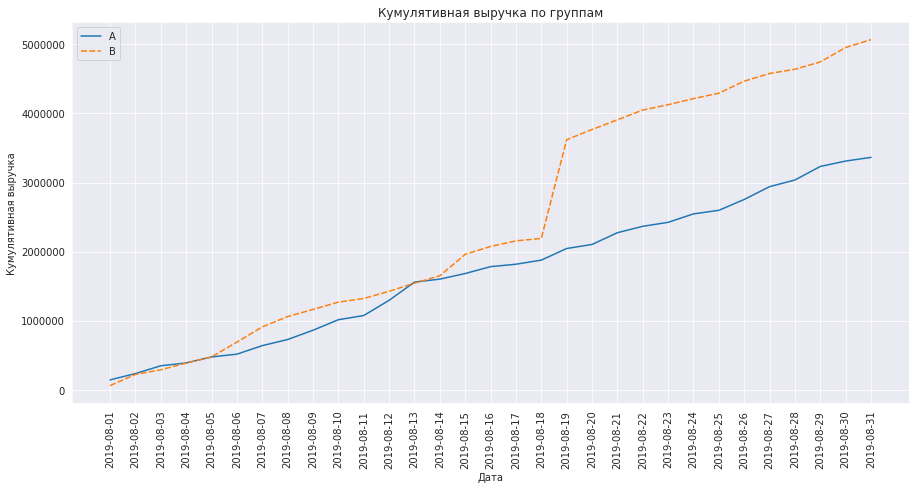

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,142779,234381,346854,388030,474413,515332,638580,727219,861456,1013731,1074396,1294788,1558426,1601692,1682569,1782420,1817160,1876741,2044934,2103613,2273782,2366147,2424010,2546023,2597907,2755121,2940471,3036933,3233233,3311413,3364656
B,59758,221801,288850,385740,475648,690490,909654,1059795,1162961,1268123,1321183,1425237,1542928,1650268,1960427,2074677,2155542,2190865,3620785,3768059,3908406,4050134,4127403,4215269,4294526,4467965,4579312,4640510,4746610,4955833,5068972


In [11]:
orders_revenue_cum = orders_df.pivot_table(index = 'date', columns = 'group', values = 'revenue', aggfunc = 'sum').cumsum()

plot_group(orders_revenue_cum, title = 'Кумулятивная выручка по группам',  ylabel='Кумулятивная выручка')

#### Выводы:
* Больше половины периода наблюдений выручка по группам примерно совпадала (обычно с небольшим превышением группы B над A), но 19.08 группа B резко скакнула вверх, а дальше опять графики остались примерно параллельными, но превышение B над A остаётся стабильно большим.
* Похоже, 19.08 случился аномальный всплеск выручки в группе B, который надо будет вычленить.

### 2.2 Кумулятивный средний чек по группам.

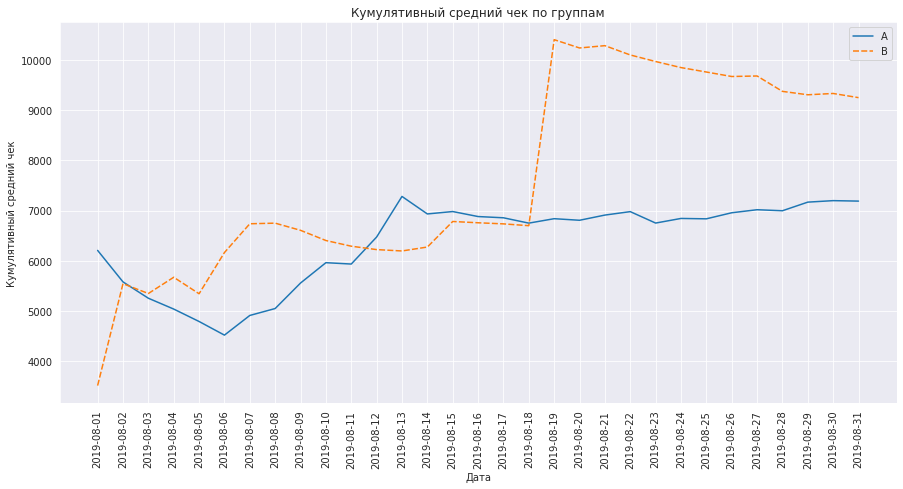

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
A,6207.78,5580.50,5255.36,5039.35,4792.05,4520.46,4912.15,5050.13,5557.78,5963.12,5935.89,6473.94,7282.36,6933.73,6981.61,6881.93,6857.21,6750.87,6839.24,6807.81,6911.19,6979.78,6752.12,6844.15,6836.60,6957.38,7017.83,6997.54,7169.03,7198.72,7189.44
B,3515.18,5545.02,5349.07,5672.65,5344.36,6165.09,6738.18,6750.29,6607.73,6404.66,6291.35,6223.74,6196.50,6274.78,6783.48,6757.91,6736.07,6699.89,10404.55,10239.29,10285.28,10100.08,9969.57,9848.76,9760.29,9670.92,9681.42,9374.77,9307.08,9333.02,9249.95


In [12]:
orders_n_cum = orders_df.pivot_table(index = 'date', columns = 'group', values = 'transactionId', aggfunc = 'count').cumsum()

orders_avg_pays_cum = pd.DataFrame()
orders_avg_pays_cum['A'] = orders_revenue_cum['A']/orders_n_cum['A']
orders_avg_pays_cum['B'] = orders_revenue_cum['B']/orders_n_cum['B']

plot_group(orders_avg_pays_cum, title = 'Кумулятивный средний чек по группам',  ylabel='Кумулятивный средний чек')

#### Выводы:
* После сильных колебаний в начале периода, средний чек в обеих группах к середине месяца стал стабилизироваться около 7000. Но 19.08 в группе B он в полтора раза рванул вверх. После этого стал плавно снижаться. Версия об аномалии 19.08 подтверждается

---

<div class="alert alert-block alert-success">
    

### Комментарий ревьюера

Совершенно верно. Вид графика группы В после 19.08 -- это так называемое "возвращение к среднему". Очень характерно для единоразовых мощных выбросов
</div>

---

### 2.3 Относительное изменение кумулятивного среднего чека группы B к группе A.

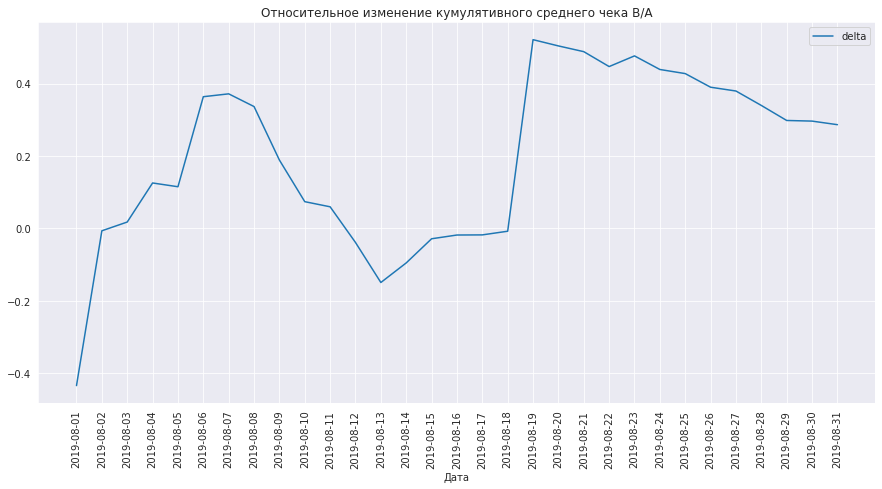

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
delta,-0.43,-0.01,0.02,0.13,0.12,0.36,0.37,0.34,0.19,0.07,0.06,-0.04,-0.15,-0.10,-0.03,-0.02,-0.02,-0.01,0.52,0.50,0.49,0.45,0.48,0.44,0.43,0.39,0.38,0.34,0.30,0.30,0.29


In [13]:
orders_avg_pays_cum['delta'] = orders_avg_pays_cum['B']/orders_avg_pays_cum['A']-1
plot_group(orders_avg_pays_cum.filter(['delta']), title = 'Относительное изменение кумулятивного среднего чека B/A', ylabel='')

#### Выводы:
* В начале колебание относительного изменения среднего чека от -0.4 до 0.4, в середине месяца выходим практически на их равенство, но 19.08 резкий скачок до 0,5 с последующим плавным падением до 0,3

### 2.4 Кумулятивная конверсия по группам.

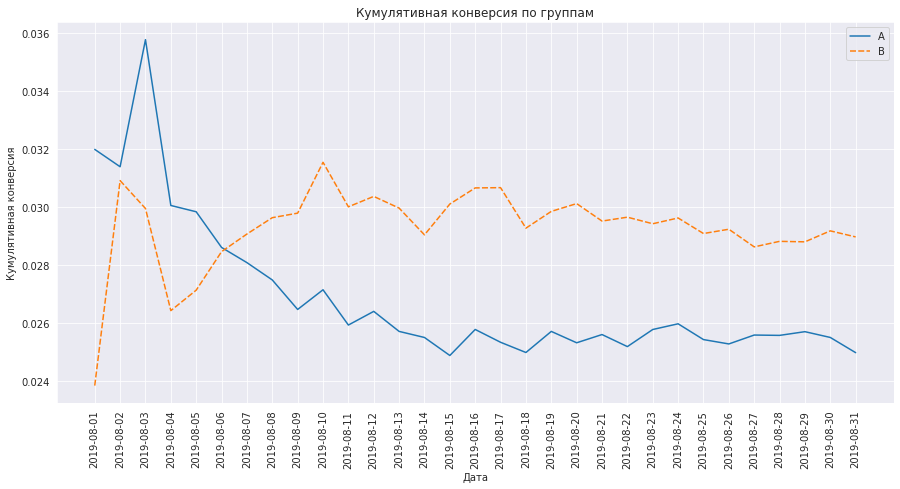

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
A,0.03,0.03,0.04,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.02
B,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03


In [14]:
visitors_n_cum = visitors_df.pivot_table(index = 'date', columns='group', values='visitors', aggfunc='sum').cumsum()

conversion_cum = pd.DataFrame()
conversion_cum['A'] = orders_n_cum['A']/visitors_n_cum['A']
conversion_cum['B'] = orders_n_cum['B']/visitors_n_cum['B']

plot_group(conversion_cum, title = 'Кумулятивная конверсия по группам',  ylabel='Кумулятивная конверсия')

#### Выводы:
* Если отбросить большие колебания в начальный период, то со второй декады месяца в группе B конверсия в районе 3% с некоторой тенденцией к уменьшению, а в A в районе 2.5-2.6%

### 2.5 Относительное изменение кумулятивной конверсии группы B к группе A.

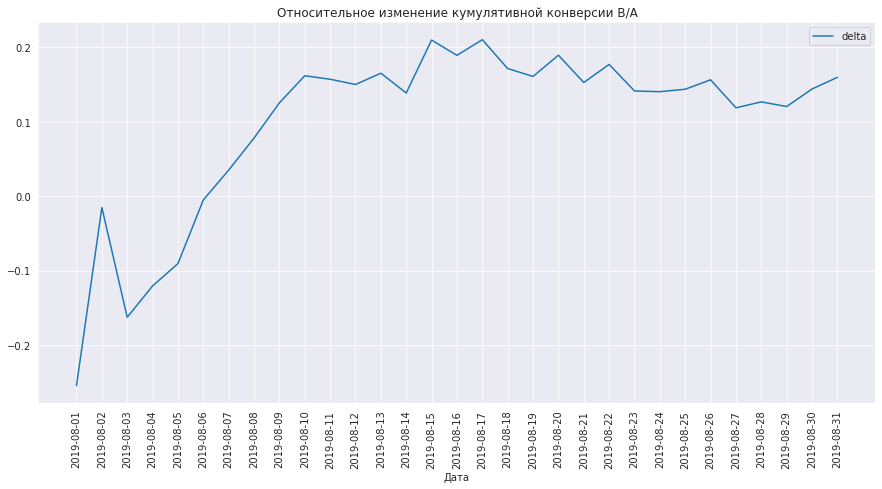

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
delta,-0.25,-0.02,-0.16,-0.12,-0.09,-0.01,0.04,0.08,0.13,0.16,0.16,0.15,0.17,0.14,0.21,0.19,0.21,0.17,0.16,0.19,0.15,0.18,0.14,0.14,0.14,0.16,0.12,0.13,0.12,0.14,0.16


In [15]:
conversion_cum['delta'] = conversion_cum['B']/conversion_cum['A']-1
plot_group(conversion_cum.filter(['delta']), title = 'Относительное изменение кумулятивной конверсии B/A', ylabel='')

#### Выводы:
* К 10.08 относительное изменение кумулятивной конверсии дошло до 0,15 и далее колебалось в интервале 0,14..0,21.

### 2.6 Точечный график количества заказов по пользователям.

In [16]:
def scatter_plot_y(y, title, ylable):
    """Вывод Series y в виде точечного графиком с X в виде порядкового номера"""

    plt.figure(figsize = (15, 2))
    ax = sns.scatterplot(x= range(0,len(y)), y = y, linewidth = 0)
    ax.set_title(title)
    ax.set(xlabel='', ylabel=ylable)
    plt.show()

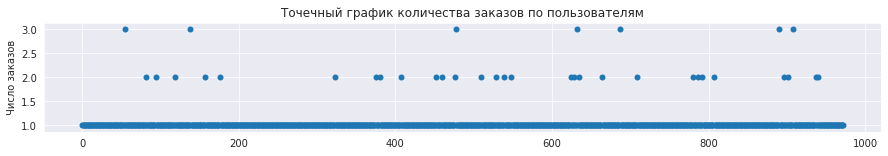

,count_users
count_orders,
1,937
2,29
3,7


In [17]:
orders_by_users = orders_df.groupby('visitorId').agg(count_orders = ('transactionId', 'count'))

scatter_plot_y(orders_by_users['count_orders'], 'Точечный график количества заказов по пользователям', 'Число заказов')
display(orders_by_users.groupby('count_orders').agg(count_users = ('count_orders', 'count'))) 

#### Выводы:
* Кажется, пожелание построить точечный график по количеству заказов по пользователям не сильно логично в данном случае. Нагляднее просто табличка число ордеров - число пользователей. Но в любом случае видно, что подавляющее большинство пользователей совершает всего одну покупку - таковых 937 пользователей. Более одной покупки сделали всего 29+7=36 пользователей.

### 2.7 Перцентили количества заказов на пользователя. Выбор границы для определения аномальных пользователей.

In [18]:
print('Перцентиль [95, 99] = ' + str(np.percentile(orders_by_users['count_orders'], [95, 99])))

Перцентиль [95, 99] = [1. 2.]


#### Выводы:
* 95% пользователей совершают всего одну покупку. 99% пользователей сделали не более 2х покупок.
* Примем за норму число заказов не более 2х.

### 2.8 Точечный график стоимостей заказов.

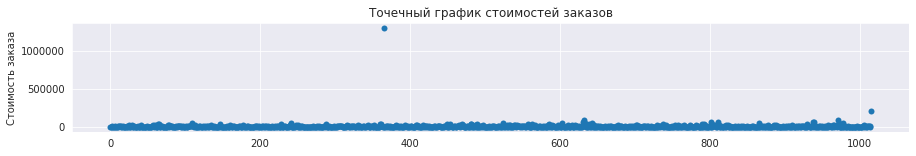

,transactionId,visitorId,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
1196,3936777065,2108080724,2019-08-15,202740,B


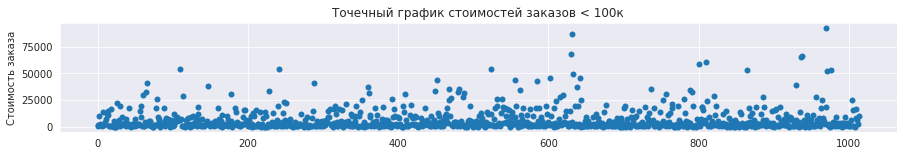

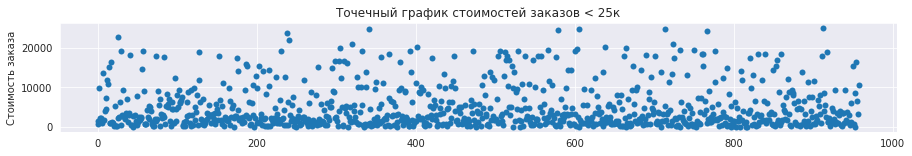

In [19]:
scatter_plot_y(orders_df['revenue'], 'Точечный график стоимостей заказов', 'Стоимость заказа')

show_html_tag('h4', 'Ордера > 100к')
display(orders_df.query('revenue > 100000'))
scatter_plot_y(orders_df.query('revenue < 100000')['revenue'], 'Точечный график стоимостей заказов < 100к', 'Стоимость заказа')
scatter_plot_y(orders_df.query('revenue < 25000')['revenue'], 'Точечный график стоимостей заказов < 25к', 'Стоимость заказа')

#### Выводы:
* Обнаружилась явная причина аномалии в группе B -  19.08 один ордер почти на 1.3М при том, что подавляющее число ордеров не более чем на 25к.

### 2.9 Перцентили стоимости заказов. Выбор границы для определения аномальных заказов.

In [20]:
print('Перцентиль [95, 99] = ' + str(np.percentile(orders_df['revenue'], [95, 99])))

Перцентиль [95, 99] = [26785. 53904.]


#### Выводы:
* 95% покупок сделаны на сумму не более 26785.
* 99% на сумму не более 53904.
* Примем за норму 95-ый перцентиль, т.е. 26785.

### 2.10 Статистическая значимость различий в конверсии между группами по «сырым» данным.

In [21]:
def statistical_significance_of_conversion(orders, visitors):
    """подсчитываем статистическую значимость различий в конверсии на основе датафреймов ордеров и визитов"""
    # group = ('group', 'first') - допустимо, т.к. пользователи входившие в обе группы уже удалены
    orders_by_visitorId = orders.groupby('visitorId').agg(n_orders = ('transactionId', 'count'), group = ('group', 'first'))

    sampleA = pd.concat(
                [
                    orders_by_visitorId.query('group == "A"')['n_orders'],
                    pd.Series(0, index=np.arange(
                                        visitors.query('group == "A"')['visitors'].sum() 
                                            - len(orders_by_visitorId.query('group == "A"'))
                                        ), 
                              name='n_orders')
                ],
            axis=0)

    sampleB = pd.concat(
                [
                    orders_by_visitorId.query('group == "B"')['n_orders'],
                    pd.Series(0, index=np.arange(
                                        visitors.query('group == "B"')['visitors'].sum() 
                                            - len(orders_by_visitorId.query('group == "B"'))
                                        ), 
                              name='n_orders')
                ],
            axis=0)

    print("p-value: {0:.5f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))
    conversionA = len(orders.query('group=="A"'))/visitors.query('group=="A"')['visitors'].sum()
    conversionB = len(orders.query('group=="B"'))/visitors.query('group=="B"')['visitors'].sum()
    print("Относительное различие в конверсии B/A: {0:.3f}".format( conversionB/conversionA - 1))    

In [22]:
statistical_significance_of_conversion(orders_df, visitors_df)

p-value: 0.00551
Относительное различие в конверсии B/A: 0.160


#### Выводы:
* p-значение весьма мало - 0.00551, относительное отличие в конверсии достаточно велико - 16%
* Отвергаем нулевую гипотезу о равенстве средней конверсии: между группами в сырых данных есть значимая разница

### 2.11 Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным.

In [27]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(
                                        orders_df.query('group == "A"')['revenue'], 
                                        orders_df.query('group == "B"')['revenue']
                                    )[1]))
print("Относительное отличие среднего чека B/A: {0:.3f}".format(orders_df.query('group == "B"')['revenue'].mean()/
                       orders_df.query('group == "A"')['revenue'].mean()
                       -1))

p-value: 0.415
Относительное отличие среднего чека B/A: -0.223


#### Выводы:
* p-значение велико - 0.415, относительная разница в среднем чеке так же велика - 22%
* Отвергнуть нулевую гипотезу о равенстве среднего чека нельзя.

### 2.12 Статистическая значимость различий в конверсии между группами по «очищенным» данным.

In [24]:
# Подчищаем данные от выбросов по числу ордеров и по размеру ордера

# Да, знаю, что раньше считали и можно использовать готовое. Но так нагляднее, а данных не много
orders_by_users = orders_df.groupby('visitorId').agg(count_orders = ('transactionId', 'count')).reset_index()

usersWithManyOrders = orders_by_users.query('count_orders > 2')['visitorId']
usersWithExpensiveOrders = orders_df.query('revenue > 26785')['visitorId']

abnormalUsers = pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis = 0).drop_duplicates().to_list()

orders_without_abnormal = orders_df.query('visitorId not in @abnormalUsers')

print('Число ордеров до удаления выбросов: ' + str(len(orders_df)))
print('Число ордеров после удаления выбросов: ' + str(len(orders_without_abnormal)))

statistical_significance_of_conversion(orders_without_abnormal, visitors_df)

Число ордеров до удаления выбросов: 1016
Число ордеров после удаления выбросов: 943
p-value: 0.00623
Относительное различие в конверсии B/A: 0.182


#### Выводы:
* Избавляясь от выбросов, мы удалили 1016 - 943 = 73 ордера.
* p-значение подросло с 0.00551 до 0.00623, но всё равно остаётся слишком малым, поэтому вывод не изменился: 
  * Отвергаем нулевую гипотезу о равенстве средней конверсии: между группами и в очищенных данных есть значимая разница
* Различие в конверсии ещё увеличилось с 0,16 до 0,18


### 2.13 Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным.

In [25]:
print("p-value: {0:.3f}".format(st.mannwhitneyu(
                                        orders_without_abnormal.query('group == "A"')['revenue'], 
                                        orders_without_abnormal.query('group == "B"')['revenue']
                                    )[1]))
print("Относительное отличие среднего чека: {0:.3f}".format(orders_without_abnormal.query('group == "A"')['revenue'].mean()/
                       orders_without_abnormal.query('group == "B"')['revenue'].mean()
                       -1))

p-value: 0.323
Относительное отличие среднего чека: 0.051


#### Выводы:
* После очистки от выбросов, p-значение для различий среднего чека уменьшиилось с 0,415 до 0,323, но остаётся большим. Поэтому отвергнуть нулевую гипотезу о равенстве среднего чека нельзя.
* Относительное отличие среднего чека упало с 0,223 до 0,051

### 2.14 Решение по результатам теста.

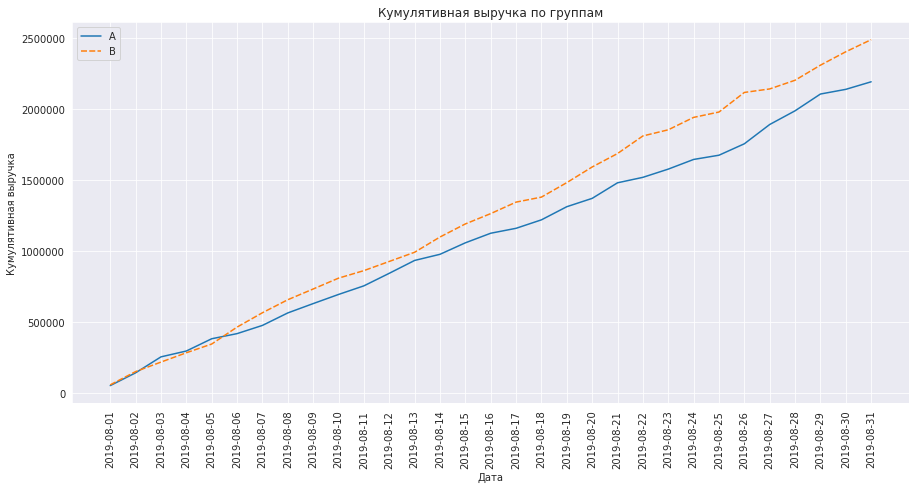

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
group,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,54351,144263,256736,297912,384295,420384,478232,566181,631848,696233,756898,845230,935778,979044,1059921,1127422,1162162,1221743,1314266,1372945,1482664,1521125,1578988,1647097,1676941,1757415,1893270,1989732,2107807,2140837,2194080
B,59758,152992,220041,285581,347139,466292,567503,659094,734660,811072,864132,928686,993477,1100817,1192959,1265689,1346554,1381877,1483892,1594016,1688736,1812596,1855895,1943271,1981078,2119032,2143759,2204957,2311057,2405560,2490714


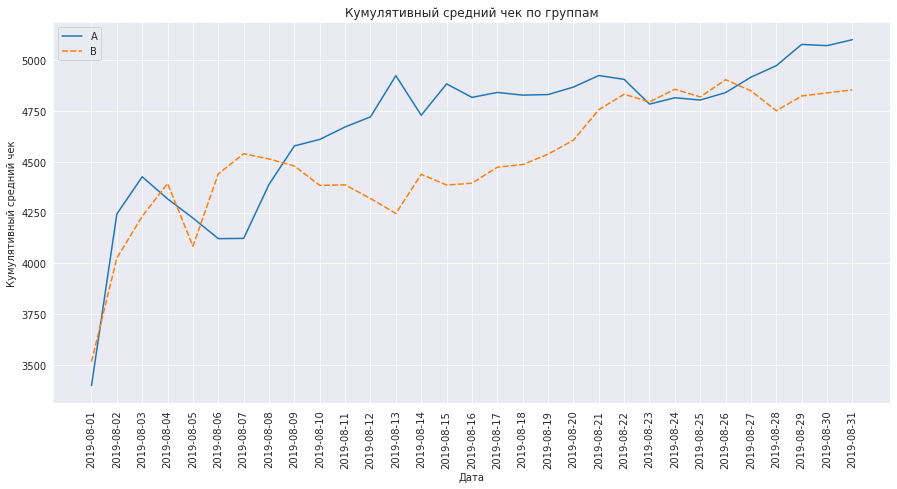

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
A,3396.94,4243.03,4426.48,4317.57,4223.02,4121.41,4122.69,4389.00,4578.61,4610.81,4672.21,4721.96,4925.15,4729.68,4884.43,4818.04,4842.34,4829.02,4831.86,4868.60,4925.79,4906.85,4784.81,4816.07,4804.99,4841.36,4917.58,4974.33,5079.05,5073.07,5102.51
B,3515.18,4026.11,4231.56,4393.55,4083.99,4440.88,4540.02,4514.34,4479.63,4384.17,4386.46,4319.47,4245.63,4438.78,4385.88,4394.75,4473.60,4486.61,4537.90,4606.98,4757.00,4833.59,4795.59,4858.18,4820.14,4905.17,4850.13,4752.06,4824.75,4840.16,4855.19


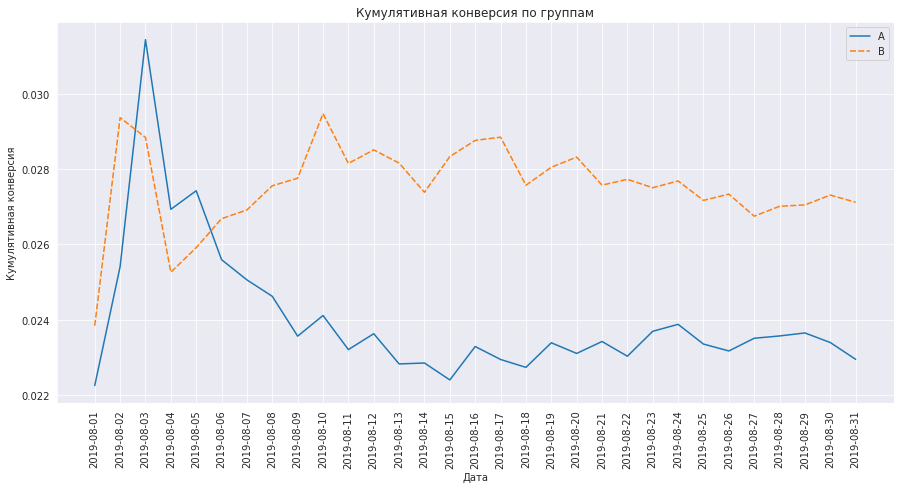

date,2019-08-01,2019-08-02,2019-08-03,2019-08-04,2019-08-05,2019-08-06,2019-08-07,2019-08-08,2019-08-09,2019-08-10,2019-08-11,2019-08-12,2019-08-13,2019-08-14,2019-08-15,2019-08-16,2019-08-17,2019-08-18,2019-08-19,2019-08-20,2019-08-21,2019-08-22,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31
A,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02,0.02
B,0.02,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03,0.03


In [26]:
show_html_tag('h3', 'Графики по очищенным от выбросам данным')

orders_revenue_cum = orders_without_abnormal.pivot_table(index = 'date', columns = 'group', values = 'revenue', aggfunc = 'sum').cumsum()

plot_group(orders_revenue_cum, title = 'Кумулятивная выручка по группам',  ylabel='Кумулятивная выручка')

orders_n_cum = orders_without_abnormal.pivot_table(index = 'date', columns = 'group', 
                                                   values = 'transactionId', aggfunc = 'count').cumsum()

orders_avg_pays_cum = pd.DataFrame()
orders_avg_pays_cum['A'] = orders_revenue_cum['A']/orders_n_cum['A']
orders_avg_pays_cum['B'] = orders_revenue_cum['B']/orders_n_cum['B']

plot_group(orders_avg_pays_cum, title = 'Кумулятивный средний чек по группам',  ylabel='Кумулятивный средний чек')

visitors_n_cum = visitors_df.pivot_table(index = 'date', columns='group', values='visitors', aggfunc='sum').cumsum()

conversion_cum = pd.DataFrame()
conversion_cum['A'] = orders_n_cum['A']/visitors_n_cum['A']
conversion_cum['B'] = orders_n_cum['B']/visitors_n_cum['B']

plot_group(conversion_cum, title = 'Кумулятивная конверсия по группам',  ylabel='Кумулятивная конверсия')

#### Выводы:
* Анализ показал, что по группе B конверсия превосходит конверсию по группе A. При этом, конверсия стабилизировалась, в последние полмесяца значимых изменений нет. Можно признать, что по этому критерию группа B лучше группы A. Критерий Манна-Уитни отвергает равенство конверсий.
* По среднему чеку ситуация не столь однозная. Критерий Манна-Уитни показывает, что возможно, средний чек совпадает. График так же говорит об этом - пересечения линий групп во второй половине месяца случаются дважды. При этом они сильно не расходятся. Можно сделать предположение, сильного расхождения по среднему чеку нет.
* Общий вывод: период наблюдения достаточный, кумулятивные графики стабилизировались. Средний чек примерно равен, конверсия у B выше. Значит, вариант B более перспективен. Это подверждается и выручкой - она в B выше.

## Общий вывод

### Гипотезы
* Представлено на анализ 9 гипотез. Все коэффициенты находятся в диапазоне 1..10, за исключением `Confidence`, который 1..9
* Достаточно странно выглядит Reach=3 для изменения фона главной страницы. Вижу два варианта - или маркетологи ошиблись с оценкой охвата по этому пункту или заходов через главную страницу не много. Так же кажется сомнительным Reach=2 для своей доставки.
* Если приоритизировать по ICE (т.е. не учитывать охват), то самыми перспективными выглядят следующие гипотезы:
  * Запустить акцию, дающую скидку на товар в день рождения
  * Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
  * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок  
* Добавив учёт охвата (т.е. используя RICE) то TOP3 изменится (у третьей и четвёртой позиций RICE SCORE одинаковый):
  * Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
  * Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
  * Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
  * Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	


### A/B тест.
1. Изначально предоставлены данные по 1197 ордерам и 37652 визитам за август 2019. Данные по ордерам представлены единичными записями по каждому ордеру, данные по визитам агрегированы по дням и группам. Распределение по группам в визитах равномерное 18736/18916
2. 181 ордер (15%) принадлежат 58 пользователям, одновременно входящим в обе группы. Это некорректные ордеры и такое их большое число говорит о возможных сбоях в проведении эксперимента. **В идеале, стоит эксперимент перепровести.** Но так как нам это невозможно, то просто удалим эти ордера.
3. В группе B есть два заказа (1,3М и 200к), которые явно выбиваются из обычного размера и сильно влияют на результат эксперимента.
4. Для очистки от выбросов, выберем пользователей не более чем с 2 заказами (99ый перцентиль по числу заказов на пользователя) и чек не более 26785 (95ый перцентиль по размеру чека). После такой очистки, останется 943 ордера.
5. Анализ по очищенным данным показывает: гипотезу о различии среднего чека нельзя отвергнуть (p-value=0.323), а по конверсии группа B имеет лучшие результаты (относительное различие 18%), что закрепляется низким значением p-value = 0,00623
6. Кумулятивные графики конверсии и среднего чека стабилизировались, больших колебаний на них нет. **Можно эксперимент считать успешно законченным и сделать вывод, что группа B для нас выгоднее за счёт более высокой конверсии.**


